In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh_rev.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5677
    # of edges   =   16908
    # of cells   =   11232
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.455E-02
    hmax =  1.152E-01
  Surface grounded at vertex    1537


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    5.5519999999999996E-003


In [5]:
delta = -0.5
fix_xloc = True  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [6]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

In [7]:
#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

#Set upper bounds on divertor coils
coil_bounds[-5:-1, 0] = -122448.979592
coil_bounds[-5:-1, 1] = 122448.979592

mygs.set_coil_bounds(coil_bounds)

In [8]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [9]:
# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

In [10]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)



x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

In [11]:
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.4285E+01  6.5210E+00  6.1418E-02  1.0468E+00 -3.5512E-05 -0.0000E+00
     2  1.3555E+01  6.3289E+00  1.3779E-02  1.0434E+00 -3.6075E-05 -0.0000E+00
     3  1.3203E+01  6.2313E+00  3.3997E-03  1.0406E+00 -3.6007E-05 -0.0000E+00
     4  1.3018E+01  6.1801E+00  1.2622E-03  1.0388E+00 -3.8526E-05 -0.0000E+00
     5  1.2917E+01  6.1523E+00  6.7133E-04  1.0376E+00 -3.9660E-05 -0.0000E+00
     6  1.2860E+01  6.1368E+00  3.8951E-04  1.0369E+00 -3.3673E-05 -0.0000E+00
     7  1.2828E+01  6.1281E+00  2.2701E-04  1.0364E+00 -2.9437E-05 -0.0000E+00
     8  1.2810E+01  6.1230E+00  1.3144E-04  1.0362E+00 -2.6394E-05 -0.0000E+00
     9  1.2799E+01  6.1201E+00  7.5629E-05  1.0360E+00 -2.4199E-05 -0.0000E+00
    10  1.2793E+01  6.1184E+00  4.3307E-05  1.0360E+00 -2.2575E-05 -0.0000E+00
    11  1.2790E+01  6.1174E+00  2.4710E-05  1.0359E+00 -2.1346E-05 -0.0000E+00
    12  1.2788E+01  6.1168E+00  1.4063E-05  1.0359E+00 -2.0402E-05 -0.0000E+00
    13  1.2787E+01  6.

0

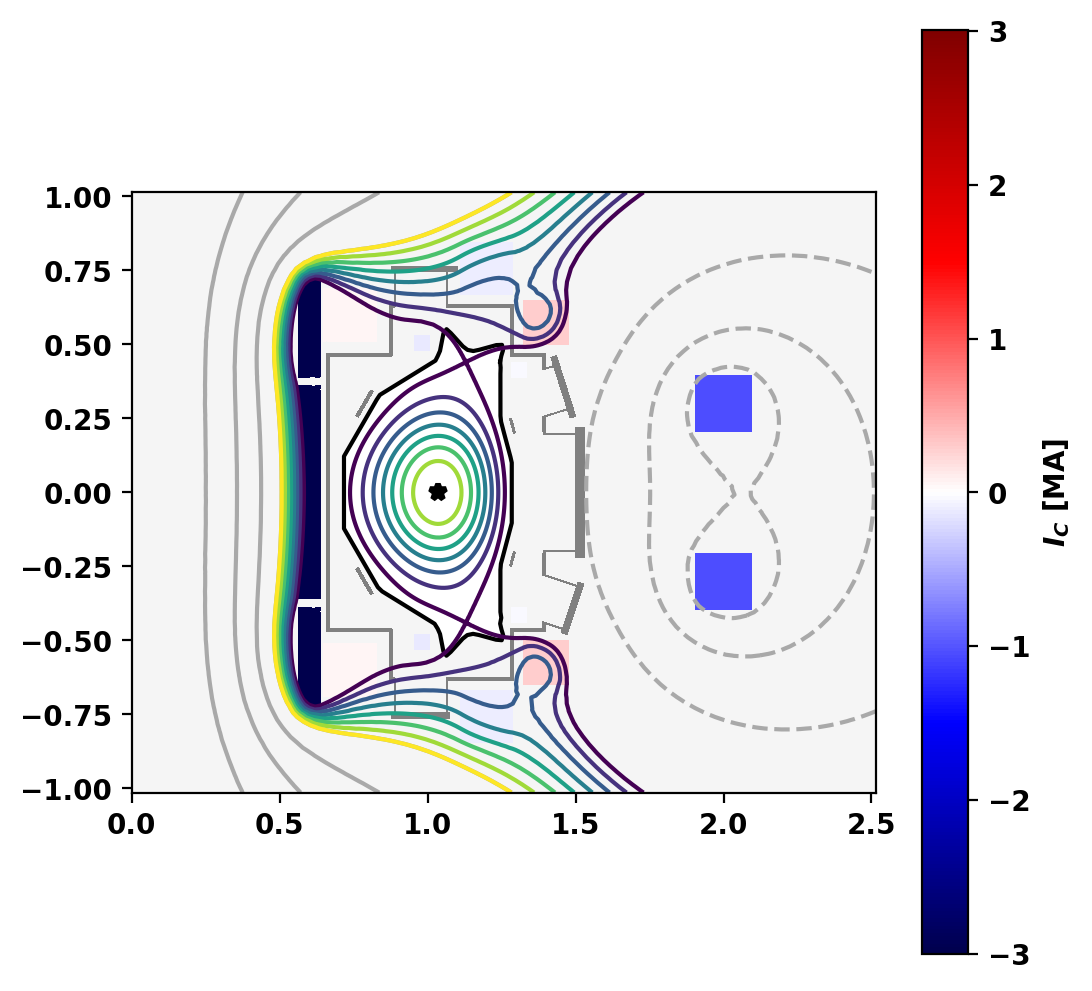

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)


